In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from telassar import PVSlice
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import astropy.units as u

In [9]:
file = "../astrodata/hd163296/data/hd163296_HAlpha_pvslice.fits"

pvslice = PVSlice(file)

In [13]:
o00 = pvslice.spectral_window(vmin=6280, vmax=6325, unit=True)
# oi00 = pvslice.spectral_window(vmin=6280, vmax=6325, unit=True)
o00.info()

[INFO] PVSlice (../astrodata/hd163296/data/hd163296_HAlpha_pvslice.fits)
[INFO] Data shape: (376 x 37) (arcsec, Angstrom)
[INFO] Spatial Offset: min: -37.6" max: 37.4" step: 0.200"
[INFO] Spectral extent: min 6280.00 Angstrom max: 6325.00 Angstrom step: 1.250 Angstrom


In [18]:
o00.register_skylines("~/astrodata/badlines.dat")
# tstr = "astrodata/badlines.dat"

# if tstr.startswith("~"):
# tp = pathlib.Path(tstr).expanduser()

In [19]:
o00._skylines

{'Hg4358.34': ['4353.0', '4363.0'],
 'Hg5460.74': ['5456.0', '5466.0'],
 'OI5577.35': ['5572.0', '5582.0'],
 'OI6300.23': ['6297.5', '6301.25'],
 'OI6363.88': ['6359.0', '6369.0']}

In [20]:
o00.unregister_skylines()

o00._skylines

[WARNING] Removing skyline info!


<IPython.core.display.Javascript object>


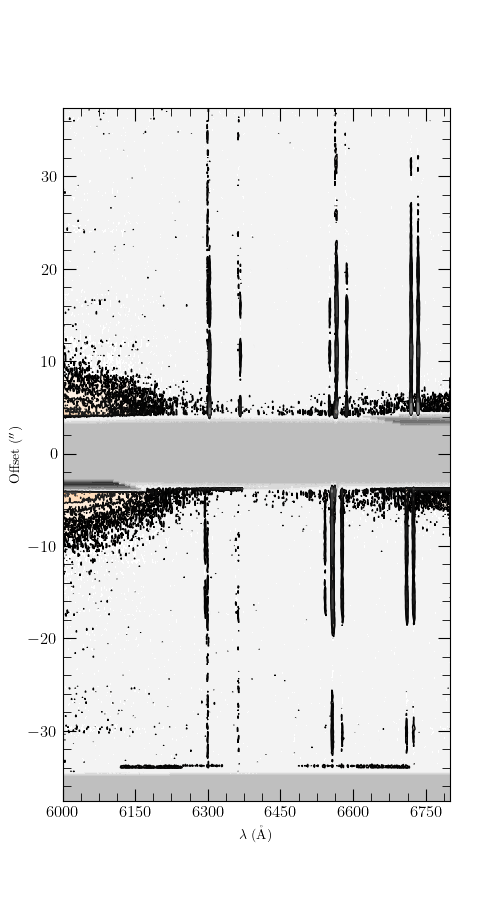

<AxesSubplot:xlabel='$\\lambda$ ($\\mathrm{\\mathring{A}}$)', ylabel='Offset ($\\mathrm{{}^{\\prime\\prime}}$)'>

In [10]:
%matplotlib notebook
pvslice.plot_contours()

# test = o00[5]

Let's try to mask skylines. Basic idea:
  * get effective wavelength range
  * mask desired region
  * loop over spatial pixels
  * spline interpolation over masked region
  
Eventually, allow inclusion of custom file to parse and mask many lines.

In [88]:
%%writefile badlines.dat
4353.0 4363.0  Hg4358.34
5456.0 5466.0  Hg5460.74
5572.0 5582.0  OI5577.35
6297.5 6301.25  OI6300.23
6359.0 6369.0  OI6363.88


Overwriting badlines.dat


In [273]:
# def _interp_skylines(obj=None, arc=None, wave=None, spat_unit=u.arcsec, spec_unit=u.angstrom):
def _interp_skylines(obj, eval_at):
    '''
    Mask a skyline
    '''
    
    line = obj.data[eval_at, :].copy()
    data = np.pad(line.compressed(), 1, 'edge')
    lbda = obj.velwave.pix2wav()
    
    # get the masked wavelengths only
    mlbda = lbda[line.mask]
    
    # get the effective wavelength range of the data
    l1, l2 = obj.velwave.pix2wav([-0.5, obj.shape[1]-0.5])

    # now make an array of it
    nwave = np.concatenate(([l1], np.compress(~line.mask, lbda), [l2]))

    # splrep returns the knot vector, spline coefficients, and
    # spline degree
    tck = sp.interpolate.splrep(nwave, data)
    
    # now evaluate it over the masked range
    filled = sp.interpolate.splev(mlbda, tck)
    return filled
    
def skysub(obj, arcs=None, unit=u.arcsec):
    
    if arcs is not None:
        print("Got an arcs value")
        arcs = np.asarray(arcs)
        if unit:
            arcs = obj.position.offset2pix(arcs, nearest=True)
        else:
            arcs = arcs.astype(int)
            print(arcs)
    else:
        print("got no arcs value")
        arcs = np.array([0, obj.shape[0]])
        
    p1, p2 = arcs
    for p in range(p1, p2):
        
        # this is ugly but it works for now
        data = obj.data[p, :]
#         print(data.mask)
        data[data.mask] = _interp_skylines(obj, eval_at=p) 
#         print(data.shape)
#         print(data)
        obj.data[p, :] = data
#     obj.data = _interp_skylines(obj, eval_at=eval_at)


def skymask(obj, wave, arcs=None, spec_unit=u.angstrom, spat_unit=u.arcsec):
    
    if spec_unit:
        p1, p2 = obj.velwave.wav2pix(wave, nearest=True)
    else:
        p1, p2 = list(map(int, wave))
        
    if arcs is not None:
        if spat_unit:
            a1, a2 = obj.position.offset2pix(arcs, nearest=True)
        else:
            a1, a2 = list(map(int, arcs))
    else:
        a1, a2 = 0, obj.shape[0]
#     data = obj.data.copy()
#     lbda = obj.velwav.pix2wav()
    
    obj.data[a1:a2, p1:p2] = np.ma.masked
    

In [274]:
test = o00.copy()

skymask(test, wave=(6297.5, 6301.15))

skysub(test, unit=None)#, arcs=(20, 50), unit=None)

# np.where(test.mask == True) #is np.ma.masked

# _interp_skylines(test, eval_at=20)
# test.data[20, :].mask

# np.ma.masked_invalid(test.data[20, :])
# for p in range(10, 15):
#     _data = test.data[p, :].copy()
#     print(_data[_data.mask])

# tarcs = np.array([])

got no arcs value


<IPython.core.display.Javascript object>


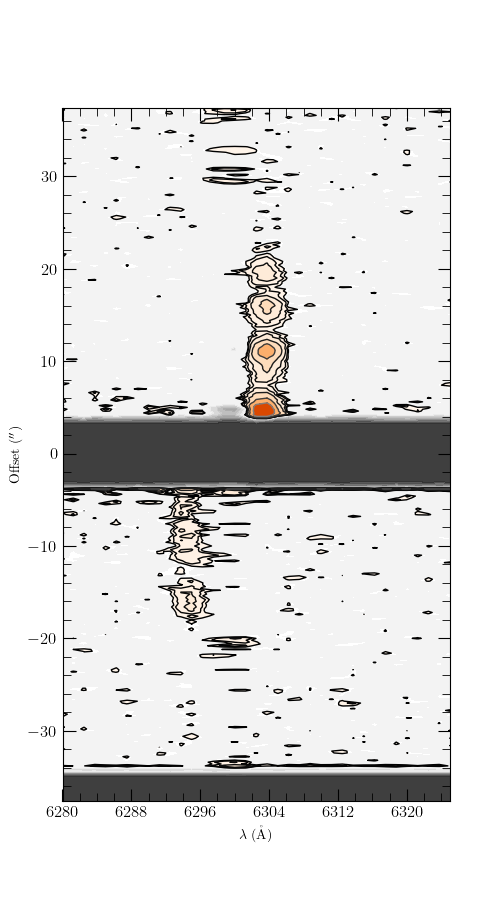

<AxesSubplot:xlabel='$\\lambda$ ($\\mathrm{\\mathring{A}}$)', ylabel='Offset ($\\mathrm{{}^{\\prime\\prime}}$)'>

In [275]:
%matplotlib notebook

test.plot_contours()

        
# w1, w2 = test.velwave.wav2pix([p1, p2], nearest=True)
# test = o00.copy()
# test.data[:, w1:w2] = np.ma.masked

In [220]:
with open("badlines.dat") as f:
    for line in f.readlines():
        p1, p2 = list(map(float, line.split()[:-1]))
        print(p1, p2)


6297.5 6301.25


In [17]:
import pathlib

path = pathlib.Path.cwd()

blines = pathlib.Path.joinpath(path, "badlines.dat")

test_dict = {}
with blines.open() as f:
    for line in f.readlines():
        l1, l2, emis = line.strip().split()
        print(l1, l2, emis)
        test_dict[emis] = [l1, l2]
        
print(test_dict)

4353.0 4363.0 Hg4358.34
5456.0 5466.0 Hg5460.74
5572.0 5582.0 OI5577.35
6295.0 6305.0 OI6300.23
6359.0 6369.0 OI6363.88
{'Hg4358.34': ['4353.0', '4363.0'], 'Hg5460.74': ['5456.0', '5466.0'], 'OI5577.35': ['5572.0', '5582.0'], 'OI6300.23': ['6295.0', '6305.0'], 'OI6363.88': ['6359.0', '6369.0']}


In [56]:
idx = 215
tobj = test.data[idx, :].copy()
tobj.shape
l1, l2 = o00.velwave.pix2wav([-0.5, o00.shape[1]-0.5])

In [101]:
# %mv badlines.dat badlines.bk

o00.register_skylines()

In [99]:
o00.skylines

AttributeError: 'PVSlice' object has no attribute 'skylines'

In [85]:
# p = pathlib.Path("~").expanduser() / "Documents"

working = pathlib.Path.cwd()
look_for = "badlines.dat"

p = working / look_for

myDict = {}
#("$HOME/telassar/badlines.dat")
# print(p.name)
# p.is_file()
if p.exists():
    for emis, l1, l2 in parse_badlines(p.name):
        myDict[emis] = [l1, l2]

In [34]:
myDict = {}

junk = myDict if myDict else None

print(junk)

None


In [26]:
from telassar.tools import parse_badlines

In [31]:
import pathlib

myPath = "../astrodata/badlines.dat"
workdir = pathlib.Path.cwd()

if (workdir / myPath).exists(): 
    for emis, l1, l2 in parse_badlines(workdir/myPath):
        print(emis, l1, l2)
    

Hg4358.34 4353.0 4363.0
Hg5460.74 5456.0 5466.0
OI5577.35 5572.0 5582.0
OI6300.23 6297.5 6301.25
OI6363.88 6359.0 6369.0


In [28]:
%mv badlines.dat badlines.bk

# %cp badlines.dat ../astrodata/badlines.dat